<a href="https://colab.research.google.com/github/butoialexandra/Determining-country-specific-engagement-in-climate-change-policies/blob/main/3_Topic_Modeling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling

Code adapted from [here](https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know?utm_source=datacamp&utm_medium=post&utm_campaign=blog-pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know)


Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Check you're in the right place

In [2]:
!pwd

/content


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


Download these libraries if haven't done already

In [ ]:
!python -m spacy download en
!pip install pyLDAvis==3.2.1

Imports

In [ ]:
import re
import numpy as np
import pandas as pd
import glob
import pickle
from pprint import pprint
from tqdm import tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.porter import PorterStemmer

import spacy

import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Load data

In [30]:
df = pd.read_csv("./data.csv") 

In [31]:
df.head(5)

,Document,NDC
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...
1,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,The means of implementation of NDCs of Sri Lan...
2,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...
3,../txts/NER_Niger_First_NDC_Translation_Englis...,to use climate financing and benefit from the ...
4,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...


Some processing

In [32]:
df['NDC_processed'] = df['NDC'].apply(lambda x: re.sub('[(),\\.!?0-9]', '', x))
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.lower())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: x.strip())
df['NDC_processed'] = df['NDC_processed'].apply(lambda x: re.sub(' +', ' ', x))
df = df[df['NDC_processed'].apply(lambda x: len(x) > 100)]

In [33]:
df = df.reset_index(drop=True)
df

,Document,NDC,NDC_processed
0,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,Cabo Verde is committed to implement the Susta...,cabo verde is committed to implement the susta...
1,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,This updated NDC updates and strengthens the f...,this updated ndc updates and strengthens the f...
2,../txts/GMB_Gambia_First_NDC_English_Paragraph...,Gambia Watershed by a) Improving disaster prep...,gambia watershed by a improving disaster prepa...
3,../txts/JOR_Jordan_First_NDC_English_Paragraph...,The estimated cost to reach the 14 target is t...,the estimated cost to reach the target is tota...
4,../txts/FSM_Micronesia_First_NDC_English_Parag...,"Moreover, national efforts to implement INDC i...",moreover national efforts to implement indc in...
...,...,...,...
10817,../txts/KHM_Cambodia_First_NDC_English_Paragra...,conducting surveillance and research on waterb...,conducting surveillance and research on waterb...
10818,../txts/URY_Uruguay_First_NDC_Translation_Engl...,The above chart contains a not exhaustive list...,the above chart contains a not exhaustive list...
10819,../txts/MAR_Morocco_First_NDC_Translation_Engl...,"principles to be respected by the state, local...",principles to be respected by the state local ...
10820,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,Integrated planning is the key means of implem...,integrated planning is the key means of implem...


In [ ]:
df.to_csv("data_processed.csv")

Process data for LDA

In [34]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        print([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def stemming(texts):
  p = PorterStemmer()
  return [p.stem_documents(text) for text in texts]

In [35]:
ndcs = df.NDC_processed.values.tolist()
words = list(sent_to_words(ndcs))

bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [36]:
data_words_nostops = remove_stopwords(words)
data_stemmed = stemming(data_words_nostops)
data_words_bigrams = make_bigrams(data_stemmed)

Make corpus

In [37]:
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

Train gensim LDA model with 10 topics

In [38]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [39]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"island" + 0.025*"increas" + 0.024*"flood" + 0.021*"temperatur" + '
  '0.020*"rise" + 0.018*"drought" + 0.017*"countri" + 0.016*"affect" + '
  '0.014*"rainfal" + 0.013*"result"'),
 (1,
  '0.091*"emiss" + 0.036*"ghg" + 0.030*"sector" + 0.030*"project" + '
  '0.027*"reduct" + 0.021*"year" + 0.019*"growth" + 0.018*"carbon" + '
  '0.016*"reduc" + 0.016*"estim"'),
 (2,
  '0.038*"nation" + 0.025*"contribut" + 0.018*"target" + 0.016*"indc" + '
  '0.015*"ndc" + 0.014*"achiev" + 0.013*"countri" + 0.011*"identifi" + '
  '0.011*"commun" + 0.011*"inform"'),
 (3,
  '0.046*"forest" + 0.045*"area" + 0.029*"natur" + 0.029*"popul" + '
  '0.025*"protect" + 0.022*"econom" + 0.018*"high" + 0.015*"peopl" + '
  '0.014*"social" + 0.014*"resourc"'),
 (4,
  '0.113*"us" + 0.041*"land" + 0.031*"data" + 0.024*"forestri" + 0.020*"ipcc" '
  '+ 0.014*"valu" + 0.014*"potenti" + 0.014*"livestock" + 0.013*"includ" + '
  '0.013*"decreas"'),
 (5,
  '0.053*"develop" + 0.037*"adapt" + 0.030*"plan" + 0.029*"im

Check perplexity and coherence score

In [40]:
print('Perplexity: {}'.format(lda_model.log_perplexity(corpus)))

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: {}'.format(coherence_lda))

Perplexity: -7.249567337190181
Coherence Score: 0.5278614753593946


Visualize topics

In [41]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.252566  0.134054       1        1  24.434688
2     -0.259154 -0.006692       2        1  18.030375
1     -0.143360 -0.113570       3        1  11.962420
6      0.113938 -0.030742       4        1   9.398393
3     -0.052036 -0.104505       5        1   7.708953
8      0.087308  0.141002       6        1   7.116051
9      0.094689  0.239372       7        1   6.857648
0      0.053047 -0.247149       8        1   5.663568
4      0.157123  0.127449       9        1   5.651313
7      0.201010 -0.139219      10        1   3.176592, topic_info=            Term         Freq        Total Category  logprob  loglift
110       climat  6642.000000  6642.000000  Default  30.0000  30.0000
109        chang  5165.000000  5165.000000  Default  29.0000  29.0000
181        emiss  3946.000000  3946.000000  Default  28.0000  28.0000
9         energi  2978.000000  2978.000000  Default  27.0000  27.0000
195           us  2327.000000  2327.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1395  world_bank    90.113683    91.032644  Topic10  -4.8516   3.4392
1325     citizen    87.845074    88.763992  Topic10  -4.8771   3.4390
1476  multilater    86.656866    87.575959  Topic10  -4.8908   3.4388
1582       mobil    83.879530    84.798424  Topic10  -4.9233   3.4385
1601       usual    83.036002    83.954875  Topic10  -4.9334   3.4384

[455 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
752       2  0.999375  achiev
381       4  0.993290     act
481       1  0.997917  action
481       2  0.001957  action
219       1  0.939329   activ
...     ...       ...     ...
218       3  0.862081   would
218      10  0.134350   would
177       3  0.891739    year
177       8  0.107522    year
1155      8  0.990799    zone

[544 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 7, 4, 9, 10, 1, 5, 8])

Train LDA using Mallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = 'mallet-2.0.8/bin/mallet'

Train LDA with Mallet

In [43]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: {}'.format(coherence_ldamallet))

[(0,
  [('climat', 0.19140917198918234),
   ('chang', 0.14822486909488464),
   ('resili', 0.027763392600264686),
   ('vulner', 0.027619540825133782),
   ('commun', 0.025145290292882216),
   ('impact', 0.023246446861154266),
   ('risk', 0.022872432245813912),
   ('strengthen', 0.015593532424190114),
   ('capac', 0.01544968064905921),
   ('disast', 0.015392139939006847)]),
 (1,
  [('contribut', 0.04104208185310343),
   ('nation', 0.039655720186003524),
   ('ndc', 0.025272217889842012),
   ('agreement', 0.018686999971117467),
   ('inform', 0.01848482222799873),
   ('commit', 0.017791641394448776),
   ('global', 0.017647228720792538),
   ('indc', 0.017560581116598792),
   ('determin', 0.01730063830401756),
   ('includ', 0.01614533691476764)]),
 (2,
  [('agricultur', 0.047747881670878546),
   ('water', 0.04394232198602646),
   ('manag', 0.03921510331499926),
   ('forest', 0.03668797383677717),
   ('land', 0.03196075516574996),
   ('area', 0.03118775085476438),
   ('product', 0.0295525494276

Converd Mallet model to gensim in order to be able to visualize topics with pyLDAvis

In [44]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

mallet_model = convertldaGenToldaMallet(ldamallet)

In [45]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mallet_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.184560 -0.237534       1        1  10.445957
3      0.266394 -0.127116       2        1  10.301085
4     -0.266969  0.010384       3        1  10.203707
0      0.086045  0.228559       4        1  10.061320
9      0.000845 -0.198750       5        1  10.018875
5     -0.143054 -0.094786       6        1  10.011335
7     -0.203772  0.037977       7        1   9.808274
1     -0.165355 -0.010450       8        1   9.799263
2      0.171192  0.256857       9        1   9.718936
6      0.070115  0.134858      10        1   9.631248, topic_info=        Term         Freq        Total Category  logprob  loglift
110   climat  6990.000000  6990.000000  Default  30.0000  30.0000
109    chang  5413.000000  5413.000000  Default  29.0000  29.0000
181    emiss  4256.000000  4256.000000  Default  28.0000  28.0000
20     adapt  3529.000000  3529.000000  Default  27.0000  27.0000
9     energi  3387.000000  3387.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
479     wind   187.129063   239.299282  Topic10  -5.2301   2.0942
235   includ   342.719527  2203.427438  Topic10  -4.6250   0.4793
657   import   222.872817   643.903909  Topic10  -5.0553   1.2792
367   promot   223.924102   768.275142  Topic10  -5.0506   1.1073
441  project   198.693225  1796.869066  Topic10  -5.1702   0.1381

[714 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2755      4  0.999957    abil
347       7  0.999223  academ
317       1  0.001905  access
317       6  0.996408  access
317       8  0.001905  access
...     ...       ...     ...
177       1  0.340140    year
177       2  0.186367    year
177       5  0.473857    year
178       9  0.996154   yield
1155      2  0.996737    zone

[897 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 5, 1, 10, 6, 8, 2, 3, 7])

Train Mallet for different number of topics and choose the model with best coherence score

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [47]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=30, step=1)

100%|██████████| 28/28 [29:16<00:00, 62.74s/it]


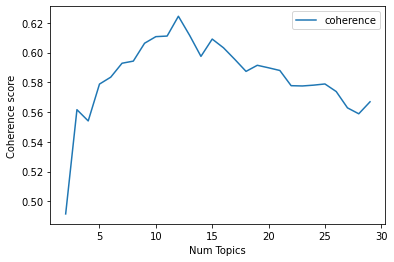

In [48]:
limit, start, step = 30, 2, 1
x = range(start, limit, step)
plt.plot(x, coherence_values, label='coherence')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.show()

In [49]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4915
Num Topics = 3  has Coherence Value of 0.5616
Num Topics = 4  has Coherence Value of 0.554
Num Topics = 5  has Coherence Value of 0.5788
Num Topics = 6  has Coherence Value of 0.5835
Num Topics = 7  has Coherence Value of 0.5929
Num Topics = 8  has Coherence Value of 0.5943
Num Topics = 9  has Coherence Value of 0.6063
Num Topics = 10  has Coherence Value of 0.6107
Num Topics = 11  has Coherence Value of 0.6111
Num Topics = 12  has Coherence Value of 0.6245
Num Topics = 13  has Coherence Value of 0.6116
Num Topics = 14  has Coherence Value of 0.5975
Num Topics = 15  has Coherence Value of 0.6091
Num Topics = 16  has Coherence Value of 0.6032
Num Topics = 17  has Coherence Value of 0.5955
Num Topics = 18  has Coherence Value of 0.5874
Num Topics = 19  has Coherence Value of 0.5915
Num Topics = 20  has Coherence Value of 0.5898
Num Topics = 21  has Coherence Value of 0.588
Num Topics = 22  has Coherence Value of 0.5778
Num Topics = 23  has Co

In [55]:
num_topics, _, optimal_model = max(list(zip(x, coherence_values, model_list)), key=lambda x: x[1])

Print top words for the best model

In [56]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"support" + 0.043*"technolog" + 0.037*"intern" + 0.036*"develop" + '
  '0.031*"capac" + 0.029*"build" + 0.028*"invest" + 0.023*"financ" + '
  '0.021*"resourc" + 0.021*"requir"'),
 (1,
  '0.017*"impact" + 0.017*"increas" + 0.016*"popul" + 0.016*"flood" + '
  '0.016*"infrastructur" + 0.016*"area" + 0.014*"region" + 0.014*"countri" + '
  '0.014*"drought" + 0.014*"coastal"'),
 (2,
  '0.220*"climat" + 0.170*"chang" + 0.073*"adapt" + 0.032*"resili" + '
  '0.029*"impact" + 0.029*"vulner" + 0.026*"risk" + 0.019*"address" + '
  '0.018*"strengthen" + 0.018*"commun"'),
 (3,
  '0.123*"develop" + 0.100*"nation" + 0.088*"plan" + 0.057*"polici" + '
  '0.046*"strategi" + 0.032*"sustain" + 0.024*"action" + 0.018*"framework" + '
  '0.016*"environment" + 0.016*"integr"'),
 (4,
  '0.048*"increas" + 0.033*"year" + 0.032*"countri" + 0.025*"econom" + '
  '0.025*"growth" + 0.023*"economi" + 0.020*"period" + 0.019*"million" + '
  '0.017*"project" + 0.013*"averag"'),
 (5,
  '0.144*"emiss" + 0.053*

In [57]:
optimal_model = convertldaGenToldaMallet(optimal_model)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.263135 -0.071826       1        1  8.829110
4      0.133779 -0.270383       2        1  8.804660
2      0.028904  0.070593       3        1  8.612215
3     -0.234927  0.109911       4        1  8.504274
9      0.232926  0.247000       5        1  8.319494
11    -0.160373 -0.104595       6        1  8.294396
5      0.022096 -0.123768       7        1  8.252251
7     -0.180902  0.063626       8        1  8.182571
0     -0.054031  0.066140       9        1  8.179803
10     0.135682  0.189347      10        1  8.177428
6     -0.169735  0.040747      11        1  8.161891
8     -0.016554 -0.216793      12        1  7.681907, topic_info=        Term         Freq        Total Category  logprob  loglift
110   climat  6867.000000  6867.000000  Default  30.0000  30.0000
109    chang  5318.000000  5318.000000  Default  29.0000  29.0000
181    emiss  4311.000000  4311.000000  Default  28.0000  28.0000
33   develop  4855.000000  4855.000000  Default  27.0000  27.0000
9     energi  3333.000000  3333.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
137    indic   311.559287   487.843024  Topic12  -4.4942   2.1179
435   follow   314.793473   603.433166  Topic12  -4.4839   1.9156
302    relev   280.295568   471.962499  Topic12  -4.5999   2.0452
500   consid   271.671072   658.802432  Topic12  -4.6312   1.6805
151     part   254.422132   445.792440  Topic12  -4.6968   2.0054

[844 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2008     11  0.995164     abl
347       8  1.009919  academ
317       5  0.005699  access
317       9  0.991550  access
317      11  0.001900  access
...     ...       ...     ...
611       8  0.918108  yangon
177       2  0.861313    year
177      12  0.138104    year
178       5  1.001946   yield
1517      8  1.003514   youth

[1101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 10, 12, 6, 8, 1, 11, 7, 9])

Save to HTML so that we can add to the website

In [58]:
p = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(p, 'lda.html')

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:236: RuntimeWarning: divide by zero encountered in log
  log_1 = np.log(pd.eval("(topic_given_term.T / topic_proportion)"))
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:259: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(pd.eval("topic_term_dists / term_proportion")).astype("float64")
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:260: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists).astype("float64")


Alternatively save to pickle

In [59]:
d = {
    "optimal_model": optimal_model,
     "corpus": corpus,
     "dictionary": id2word
}
with open('lda_model.pickle', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

Compute dominant topic for each document

In [60]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            # dominant topic
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break

    contents = df.NDC
    document = df.Document
    sent_topics_df = pd.concat([sent_topics_df, contents, document], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Document']

    return(sent_topics_df)

In [61]:
df_dominant_topic = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.NDC)

df_dominant_topic

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document
0,10.0,0.1644,"energi, gener, effici, transport, electr, rene...",Cabo Verde is committed to implement the Susta...,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...
1,8.0,0.2189,"ndc, inform, report, base, includ, data, proje...",This updated NDC updates and strengthens the f...,../txts/RWA_Rwanda_First_NDC_English_Paragraph...
2,2.0,0.1349,"climat, chang, adapt, resili, impact, vulner, ...",Gambia Watershed by a) Improving disaster prep...,../txts/GMB_Gambia_First_NDC_English_Paragraph...
3,5.0,0.1348,"emiss, ghg, sector, reduct, carbon, ga, reduc,...",The estimated cost to reach the 14 target is t...,../txts/JOR_Jordan_First_NDC_English_Paragraph...
4,11.0,0.1330,"contribut, nation, global, countri, commit, in...","Moreover, national efforts to implement INDC i...",../txts/FSM_Micronesia_First_NDC_English_Parag...
...,...,...,...,...,...
10817,1.0,0.1604,"impact, increas, popul, flood, infrastructur, ...",conducting surveillance and research on waterb...,../txts/KHM_Cambodia_First_NDC_English_Paragra...
10818,6.0,0.1045,"implement, mitig, measur, action, adapt, inclu...",The above chart contains a not exhaustive list...,../txts/URY_Uruguay_First_NDC_Translation_Engl...
10819,7.0,0.1995,"sector, govern, level, environ, process, insti...","principles to be respected by the state, local...",../txts/MAR_Morocco_First_NDC_Translation_Engl...
10820,3.0,0.1697,"develop, nation, plan, polici, strategi, susta...",Integrated planning is the key means of implem...,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...


Show most representative documents for each topic

In [62]:
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(1)], 
                                            axis=0)

sent_topics_sorteddf_mallet

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document
6069,0.0,0.4285,"support, technolog, intern, develop, capac, bu...",UNFCCC and the multilateral finance institutio...,../txts/GMB_Gambia_First_NDC_English_Paragraph...
7134,1.0,0.5563,"impact, increas, popul, flood, infrastructur, ...",Past La Nia events have shown that the impacts...,../txts/KIR_Kiribati_First_NDC_English_Paragra...
5040,2.0,0.3625,"climat, chang, adapt, resili, impact, vulner, ...","(c) Establishing early warning systems, multiu...",../txts/DMA_Dominica_First_NDC_English_Paragra...
4957,3.0,0.3707,"develop, nation, plan, polici, strategi, susta...",Malawi launched its Vision 2020 in the year 20...,../txts/MWI_Malawi_First_NDC_English_Paragraph...
7571,4.0,0.6886,"increas, year, countri, econom, growth, econom...",Figure 3.22 Projected CMIP5 21 GCMs Ensemble A...,../txts/MDA_Republic-of-Moldova_First_NDC_Engl...
5368,5.0,0.4316,"emiss, ghg, sector, reduct, carbon, ga, reduc,...",Major social and developmental setbacks Due to...,../txts/SLE_Sierra-Leone_First_NDC_English_Par...
2582,6.0,0.3933,"implement, mitig, measur, action, adapt, inclu...",4. Monitoring Report and Verification (MRV) Gh...,../txts/GHA_Ghana_First_NDC_English_Paragraph5...
6102,7.0,0.4570,"sector, govern, level, environ, process, insti...",4 The SNRCC operates at charge of the Ministry...,../txts/URY_Uruguay_First_NDC_Translation_Engl...
4601,8.0,0.5750,"ndc, inform, report, base, includ, data, proje...","11 IPCC, 2013 Summary for Policymakers. In Cli...",../txts/BRA_Brazil_First_NDC_English_Paragraph...
9035,9.0,0.4589,"water, agricultur, manag, forest, land, area, ...",Resilience has been achieved through the stre...,../txts/BOL_Bolivia-Plurinational-State-of_Fir...


Compute aggregated data for each country

In [63]:
def compute_iso(document):
  pos = document.find('_')
  return document[(pos-3):pos]

In [64]:
def country_name(document):
  pos1 = document.find('_')
  pos2 = document.find('_', pos1+1)
  return document[pos1+1:pos2]

In [67]:
def doc_topic_distribution(ldamodel, corpus, df):
    topic_distr = pd.DataFrame()
    # percentages for each topic
    for row in ldamodel[corpus]:
        percentages = [perc for topic, perc in row]
        topic_distr = topic_distr.append(pd.Series(percentages), ignore_index=True)
    # add original text, doc name, country name and ISO
    contents = df.NDC
    document = df.Document
    iso = df.Document.apply(compute_iso)
    country = df.Document.apply(country_name)

    topic_distr = pd.concat([topic_distr, contents, document, iso, country], axis=1)
    columns = [str(x) for x in range(num_topics)]
    columns.extend(['Text', 'Document', 'ISO', 'Country'])
    topic_distr.columns = columns

    return topic_distr

Compute distribution of topics in each paragraph

In [68]:
distr_df = doc_topic_distribution(optimal_model, corpus, df)
distr_df

,0,1,2,3,4,5,6,7,8,9,10,11,Text,Document,ISO,Country
0,0.071562,0.097832,0.062693,0.093846,0.056327,0.069013,0.069872,0.074852,0.056348,0.072943,0.164397,0.110314,Cabo Verde is committed to implement the Susta...,../txts/CPV_Cabo-Verde_First_NDC_English_Parag...,CPV,Cabo-Verde
1,0.063110,0.046167,0.063984,0.060405,0.048159,0.081141,0.139765,0.088007,0.218887,0.049967,0.049341,0.091068,This updated NDC updates and strengthens the f...,../txts/RWA_Rwanda_First_NDC_English_Paragraph...,RWA,Rwanda
2,0.089499,0.087571,0.134885,0.070621,0.087571,0.070621,0.074154,0.070621,0.070621,0.097146,0.076067,0.070621,Gambia Watershed by a) Improving disaster prep...,../txts/GMB_Gambia_First_NDC_English_Paragraph...,GMB,Gambia
3,0.105330,0.068712,0.061450,0.075980,0.114400,0.134774,0.061275,0.065786,0.076908,0.075980,0.062969,0.096436,The estimated cost to reach the 14 target is t...,../txts/JOR_Jordan_First_NDC_English_Paragraph...,JOR,Jordan
4,0.107189,0.085991,0.064923,0.095639,0.062211,0.081728,0.104366,0.063465,0.070410,0.068866,0.062189,0.133024,"Moreover, national efforts to implement INDC i...",../txts/FSM_Micronesia_First_NDC_English_Parag...,FSM,Micronesia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10817,0.072270,0.160351,0.101735,0.070621,0.070621,0.070621,0.072711,0.081831,0.087373,0.070621,0.070621,0.070621,conducting surveillance and research on waterb...,../txts/KHM_Cambodia_First_NDC_English_Paragra...,KHM,Cambodia
10818,0.073940,0.075961,0.089233,0.086245,0.083292,0.081614,0.104520,0.076443,0.085909,0.082231,0.089990,0.070621,The above chart contains a not exhaustive list...,../txts/URY_Uruguay_First_NDC_Translation_Engl...,URY,Uruguay
10819,0.075174,0.057078,0.060296,0.105992,0.059629,0.057078,0.087746,0.199486,0.062441,0.087819,0.058750,0.088511,"principles to be respected by the state, local...",../txts/MAR_Morocco_First_NDC_Translation_Engl...,MAR,Morocco
10820,0.089567,0.084181,0.064682,0.169675,0.081459,0.066383,0.080082,0.097335,0.062189,0.063461,0.078748,0.062237,Integrated planning is the key means of implem...,../txts/LKA_Sri-Lanka_First_NDC_English_Paragr...,LKA,Sri-Lanka


In [69]:
distr_df.to_csv("topic_distr.csv")

Compute aggregated topic distribution for each country

In [70]:
agg_df = distr_df.drop(columns=['Text', 'Document', 'Country'])
agg_df

,0,1,2,3,4,5,6,7,8,9,10,11,ISO
0,0.071562,0.097832,0.062693,0.093846,0.056327,0.069013,0.069872,0.074852,0.056348,0.072943,0.164397,0.110314,CPV
1,0.063110,0.046167,0.063984,0.060405,0.048159,0.081141,0.139765,0.088007,0.218887,0.049967,0.049341,0.091068,RWA
2,0.089499,0.087571,0.134885,0.070621,0.087571,0.070621,0.074154,0.070621,0.070621,0.097146,0.076067,0.070621,GMB
3,0.105330,0.068712,0.061450,0.075980,0.114400,0.134774,0.061275,0.065786,0.076908,0.075980,0.062969,0.096436,JOR
4,0.107189,0.085991,0.064923,0.095639,0.062211,0.081728,0.104366,0.063465,0.070410,0.068866,0.062189,0.133024,FSM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10817,0.072270,0.160351,0.101735,0.070621,0.070621,0.070621,0.072711,0.081831,0.087373,0.070621,0.070621,0.070621,KHM
10818,0.073940,0.075961,0.089233,0.086245,0.083292,0.081614,0.104520,0.076443,0.085909,0.082231,0.089990,0.070621,URY
10819,0.075174,0.057078,0.060296,0.105992,0.059629,0.057078,0.087746,0.199486,0.062441,0.087819,0.058750,0.088511,MAR
10820,0.089567,0.084181,0.064682,0.169675,0.081459,0.066383,0.080082,0.097335,0.062189,0.063461,0.078748,0.062237,LKA


In [71]:
agg_df = agg_df.groupby('ISO').mean()

Add one row with EU data for each of the EU countries as there is only one NDC for European Union

In [72]:
EU_isos = ['AUT', 'BEL', 'BGR', 'CZE', 'CYP', 'HRV', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'IRL', 'ITA', 
           'LVA', 'LTU', 'LUX', 'MLT', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'HUN', 'NLD']

In [73]:
for iso in EU_isos:
  agg_df.loc[iso] = agg_df.loc['EUU']

In [74]:
agg_df

,0,1,2,3,4,5,6,7,8,9,10,11
ISO,,,,,,,,,,,,
AFG,0.093408,0.071740,0.089282,0.087725,0.099931,0.088682,0.071271,0.074748,0.069508,0.098322,0.085704,0.069678
AGO,0.079562,0.074668,0.083852,0.072573,0.080107,0.117886,0.085861,0.070311,0.070894,0.092429,0.098233,0.073624
ALB,0.080646,0.080150,0.078390,0.085556,0.082575,0.086645,0.083393,0.080082,0.087267,0.077367,0.079458,0.098473
ARE,0.089507,0.076851,0.077505,0.080967,0.078078,0.072535,0.073036,0.079858,0.063938,0.087238,0.148517,0.071971
ARG,0.073873,0.072434,0.083661,0.069880,0.075299,0.088878,0.089094,0.110774,0.092602,0.069253,0.058465,0.115788
...,...,...,...,...,...,...,...,...,...,...,...,...
SVN,0.062501,0.056002,0.063160,0.069097,0.068705,0.126362,0.067439,0.070142,0.080951,0.088164,0.078887,0.168588
ESP,0.062501,0.056002,0.063160,0.069097,0.068705,0.126362,0.067439,0.070142,0.080951,0.088164,0.078887,0.168588
SWE,0.062501,0.056002,0.063160,0.069097,0.068705,0.126362,0.067439,0.070142,0.080951,0.088164,0.078887,0.168588


In [75]:
agg_df.to_csv("aggregated_data.csv")